pybullet build time: Sep  3 2024 12:51:03
2025-01-15 17:44:17.679541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736959457.695385  305052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736959457.699819  305052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 17:44:17.716047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't fi

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4060/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.183.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.183.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4060/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
Action: [0.6177018 0.4889228 0.5745879], Reward: 0.6965705644106882, Done: False, State: [0.0735 0.0901 0.1205 0.5    0.5    

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

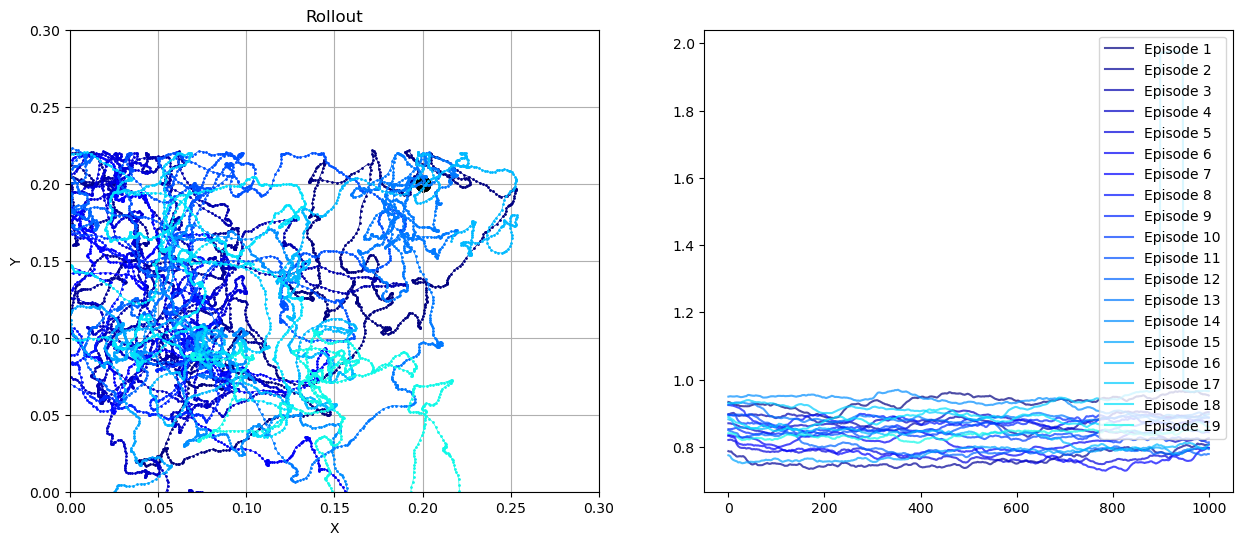

In [ ]:
import gymnasium as gym
import numpy as np
import wandb
import matplotlib.pyplot as plt  # For plotting
from new_ot2_gym_wrapper import OT2Env  # Import the custom OT2 environment
from stable_baselines3 import PPO  # Proximal Policy Optimization (PPO) algorithm
import os
from tqdm.notebook import tqdm  # For a progress bar in Jupyter notebooks

# Set up W&B notebook name for logging
os.environ["WANDB_NOTEBOOK_NAME"] = "ot2_reinforcement_learning_notebook"  # Adjust to your notebook name

# Initialize W&B project
run = wandb.init(
    project="ot2-reinforcement-learning",  # Replace with your W&B project name
    sync_tensorboard=False,  # Disable tensorboard syncing
    monitor_gym=True,  # Monitor gym environment
    save_code=True,  # Save the script in W&B
    config={
        "learning_rate": 73e-5,  # Learning rate for PPO
        "gamma": 0.90,  # Discount factor
        "epsilon": 0.1,  # Exploration parameter
        "episodes": 20,  # Number of training episodes
        "n_steps": 128  # Steps per PPO update
    }
)

# Initialize the custom environment
env = OT2Env(render=True)

# Extract configuration parameters
config = wandb.config
learning_rate = config.learning_rate
gamma = config.gamma
epsilon = config.epsilon
episodes = config.episodes
n_steps = config.n_steps

# Test the environment with random actions
for _ in range(1000):
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    print(f"Action: {action}, Reward: {reward}, Done: {done}, State: {state}")
    if done or truncated:
        env.reset()

# Define PPO agent with CPU usage
model = PPO("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma, n_steps=n_steps, verbose=2, device="cpu")

max_steps = 1001  # Maximum steps per episode

# Set up a progress bar for training
progress_bar = tqdm(range(episodes), desc="Training Progress", leave=True)

# Add noisy action function for exploration
def noisy_action(action, episode, total_episodes, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, size=action.shape)
    action_with_noise = np.clip(action + noise, -1, 1)
    return action_with_noise

# Learning rate scheduler
def lr_schedule(progress):
    return max(1e-5, 1e-3 * (1 - progress))

# Rewards history for tracking performance
rewards_history = []

# Initialize the plot for rewards per step and trajectory (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Side-by-side plots
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Rollout')

ax2.set_xlabel('Step')
ax2.set_ylabel('Reward')
ax2.set_title('Reward per Step over Episodes')

# List of colors for different trajectories
colors = plt.cm.jet(np.linspace(0, 1, episodes))  # Using a colormap to assign different colors

def rollout_chart(trajectory, goal_position, episode, color):
    """
    Plots the rollout chart for the agent's trajectory and logs it to W&B.
    Args:
        trajectory: List of agent positions during the rollout.
        goal_position: Final goal position for the episode.
        episode: Current episode number.
        color: The color for the trajectory plot.
    """
    trajectory = np.array(trajectory)  # Convert trajectory to NumPy array
    
    # Adjust the x and y limits of the plot to match the environment's range
    ax1.set_xlim(0, 0.3)  # Adjust these limits to match your environment's full range
    ax1.set_ylim(0, 0.3)

    # Clamp the goal position within the environment's limits
    goal_position_clamped = np.clip(goal_position, 0.2, 0.2)

    # Plot the trajectory and key points with reduced linewidth
    ax1.plot(trajectory[:, 0], trajectory[:, 1], '-o', label=f'Episode {episode}', color=color, markersize=1, linewidth=0.5)
    ax1.scatter(goal_position_clamped[0], goal_position_clamped[1], color='black', label='Goal Position', s=100)
    ax1.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Position', s=100)

    # Update the legend and redraw
    ax1.grid()

    # Save the chart as an image and log to W&B
    chart_path = f"rollout_chart_episode_{episode}.png"
    plt.savefig(chart_path)
    wandb.log({"rollout_chart": wandb.Image(chart_path)})

# Store rewards per step for plotting
reward_per_step_history = []

# Training loop
for episode in progress_bar:
    # Define the goal_position for the current episode
    goal_position = np.random.uniform(env.observation_space.low[:3], env.observation_space.high[:3])

    # Reset the environment (do not pass goal_position)
    state = env.reset()  # Just reset without passing the goal_position

    total_reward = 0
    done = False
    steps = 0
    steps_to_goal = None  # Variable to store steps to reach the goal

    # Initialize lists for trajectory logging and rewards per step
    trajectory = []  # Stores agent's positions
    rewards_per_step = []  # Stores rewards for each step
    trajectory.append(state[:3])  # Initial position of the agent

    while not done and steps < max_steps:
        steps += 1

        # Get action from the model
        action, _states = model.predict(state)

        # Add noise to the action
        action = noisy_action(action, episode, episodes, noise_factor=0.1)

        # Take the action in the environment
        next_state, reward, done, truncated, info = env.step(action)

        # Log the agent's current position and reward
        trajectory.append(next_state[:3])
        rewards_per_step.append(reward)

        # Update total reward and state
        total_reward += reward
        state = next_state

    # Log the rollout chart for the episode with a unique color and goal_position
    rollout_chart(trajectory, goal_position, episode, color=colors[episode])

    # Log trajectory metrics to W&B
    wandb.log({
        "episode": episode,
        "goal_position": goal_position.tolist(),
        "trajectory": trajectory,  # Optional, for detailed debugging
        "total_reward": total_reward,
        "steps": steps,
        "steps_to_goal": steps_to_goal,  # Log the number of steps taken to reach the goal
        "learning_rate": learning_rate,
        "episode_length": steps
    })

    # Update the reward per step plot for this episode
    reward_per_step_history.append(rewards_per_step)
# List of colors for different trajectories
    colors = plt.cm.jet(np.linspace(0, 1, episodes))  # Using a colormap to assign different colors

    # Modify the plotting section to use consistent colors
    ax2.clear()  # Clear previous plot to update with new data
    for ep in range(episode + 1):
        ax2.plot(range(len(reward_per_step_history[ep])), reward_per_step_history[ep], 
                label=f'Episode {ep+1}', 
                color=colors[ep],  # Use the same color as the trajectory
                alpha=0.7)  # Optional: add some transparency
    
    ax2.legend()
    plt.draw()

    # Update the progress bar
    progress_bar.set_postfix({"Total Reward": total_reward, "Episode Length": steps})

    # Adjust learning rate using the scheduler
    learning_rate = lr_schedule(episode / episodes)

# Save the model (optional)
wandb.save("./ppo_model.zip")

# Close the environment
env.close()

# Keep the plot open after training
plt.ioff()
plt.show()
